In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as dp
# Prepare thresholded points for DBSCAN clustering algorithm
from math import sqrt, ceil
from sklearn.cluster import DBSCAN
import scipy as sp
import hdbscan
import copy
import seaborn as sns
import io
import matplotlib.backend_bases as plt_base

%matplotlib inline

In [3]:

def clusterize(input_img, color):
    img = color
    thresh_input = copy.deepcopy(input_img)
    #color_input = cv2.cvtColor(thresh_input, cv2.COLOR_GRAY2BGR)
    maxpoints=250000
    proxthresh=0.07

    binimg = thresh_input
    imgShow(binimg)
    X = np.transpose(np.where(binimg))# > 5))
    
    Xslice = X
    nsample = len(Xslice)
    if nsample > maxpoints:
        # Make sure number of points does not exceed DBSCAN maximum capacity
        Xslice = X[range(0,nsample,int(ceil(float(nsample)/maxpoints)))]

    # Translate DBSCAN proximity threshold to units of pixels and run DBSCAN
    pixproxthr = proxthresh * sqrt(binimg.shape[0]**2 + binimg.shape[1]**2)


    hdb = hdbscan.HDBSCAN(min_cluster_size=10,min_samples=3500, cluster_selection_epsilon=pixproxthr).fit(Xslice)
    labels = hdb.labels_.astype(int)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Find the largest cluster (i.e., with most points) and obtain convex hull   
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(hdb.labels_, dtype=bool)
  
    #core_samples_mask[hdb.validity.internal_minimum_spanning_tree.internal_nodes] = True
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    fig = plt.figure(frameon=False)
    
    plot1 = fig.add_axes([0.,0.,1.,1.])
    plot1.axis('off')
    
    clusterer = hdb
    color_palette = sns.color_palette('deep', 8)
   
    cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for i, x in enumerate(clusterer.labels_)]

    cluster_member_colors = [sns.desaturate(x, p)
                             for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
    
    
    plot1.scatter(X[:,1],X[:,0], s=50, linewidth=0, c=cluster_member_colors, alpha=1)

    #input_image_rgb = copy.deepcopy(cv2.cvtColor(road, cv2.COLOR_RGB2BGR))
    input_image_rgb = road
    plot1.imshow(input_image_rgb)
   
    # define a function which returns an image as numpy array from figure
    def get_img_from_fig(fig, dpi=100):
        buf = io.BytesIO()
        
        fig.savefig(buf, format="png", bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

    plot_img_np =  get_img_from_fig(fig)
    return plot_img_np
  
    

In [4]:
def imgShow(img):
    plt.imshow(img, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def imgsShow(images, size, labels=None, figsize=(14, 14)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, size[0]*size[1] + 1):
        ax = fig.add_subplot(size[0], size[1], i)
        if labels:
            ax.set_title(labels[i - 1])
        plt.imshow(images[i-1], cmap="gray")
        plt.xticks([]), plt.yticks([])
    plt.show()
    
def getHist(img):
    first_channel = cv2.calcHist([img], [0], None, [256],[0,256])
    second_channel = cv2.calcHist([img], [1], None, [256],[0,256])
    third_channel = cv2.calcHist([img], [2], None, [256],[0,256])
    
    first_channel = np.reshape( first_channel, (256) ).astype(np.int64)
    second_channel = np.reshape( second_channel, (256) ).astype(np.int64)
    third_channel = np.reshape( third_channel, (256) ).astype(np.int64)
    
    return (first_channel, second_channel, third_channel)

def showHist(hist, figsize=(14, 5)):
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(2, 3, 1)
    ax.set_title("l channel")
    plt.plot(hist[0], color = (0, 0, 0))
    
    ax = fig.add_subplot(2, 3, 2)
    ax.set_title("a channel")
    plt.plot(hist[1], color = (0, 0, 0))
    
    ax = fig.add_subplot(2, 3, 3)
    ax.set_title("b channel")
    plt.plot(hist[2], color = (0, 0, 0))
    
    denseties = [ np.cumsum(h) for h in hist ]
    
    ax = fig.add_subplot(2, 3, 4)
    ax.set_title("l channel density")
    plt.plot(denseties[0], color = (0, 0, 0))
    
    ax = fig.add_subplot(2, 3, 5)
    ax.set_title("a channel density")
    plt.plot(denseties[1], color = (0, 0, 0))
    
    ax = fig.add_subplot(2, 3, 6)
    ax.set_title("b channel density")
    plt.plot(denseties[2], color = (0, 0, 0))
    
    plt.show()

In [5]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_rgba(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [6]:
def colorize_threshold(th_img, clr_img):
    """
        Take thresholded image and colorized one and combine them in the way
        that where is 1 on thresholded image will be color from original one and where is 0 remains 0
    """
    new_img = copy.deepcopy(clr_img)
    mask = th_img==255
    new_img[~mask] = 0
    
    return new_img

In [7]:
def BHEMHB(hist, img):
    h, w = img.shape
    
    repeats = np.repeat( np.arange(0, 256), hist )
    median_index = int( np.floor((h*w) / 2 + 1))
    median = repeats[median_index]
    
    print(median)
    #median = 170
    
    min_val = repeats[0]
    max_val = repeats[-1]
    
    norm_hist = hist / ( h * w )
    
    p_low = norm_hist[0:median]
    p_up = norm_hist[median:]
    
    p_low = np.log2(p_low + 1)
    p_up = np.log2(p_up + 1)
    
    cs_low = np.cumsum(p_low)
    cs_up = np.cumsum(p_up)
    
    for i in range(h):
        for j in range(w):
            if img[i, j] < median:
                img[i, j] = min_val + (median - 1 - min_val) * cs_low[ img[i, j] ]
            else:
                img[i, j] = median + (max_val - median) * cs_up[ img[i, j] - median ]
                
    return img

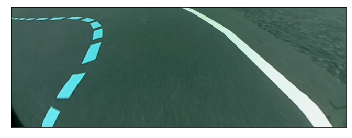

In [8]:
road = cv2.imread( "../images/jb_1.png")
#road = cv2.cvtColor( road, cv2.COLOR_BGR2RGB )
road = road[250:]
imgShow(road)

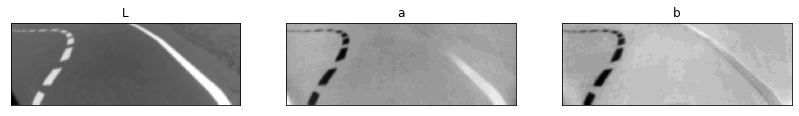

209 207 202
87 87 87


In [9]:
img_lab = cv2.cvtColor( dp(road), cv2.COLOR_RGB2LAB )
img_lab = cv2.GaussianBlur( img_lab, (15, 15), 0 )
imgsShow(cv2.split(img_lab), (1, 3), ("L", "a", "b") )
print( np.max(img_lab[0]), np.max(img_lab[1]), np.max(img_lab[2]) )
print( np.min(img_lab[0]), np.min(img_lab[1]), np.min(img_lab[2]) )

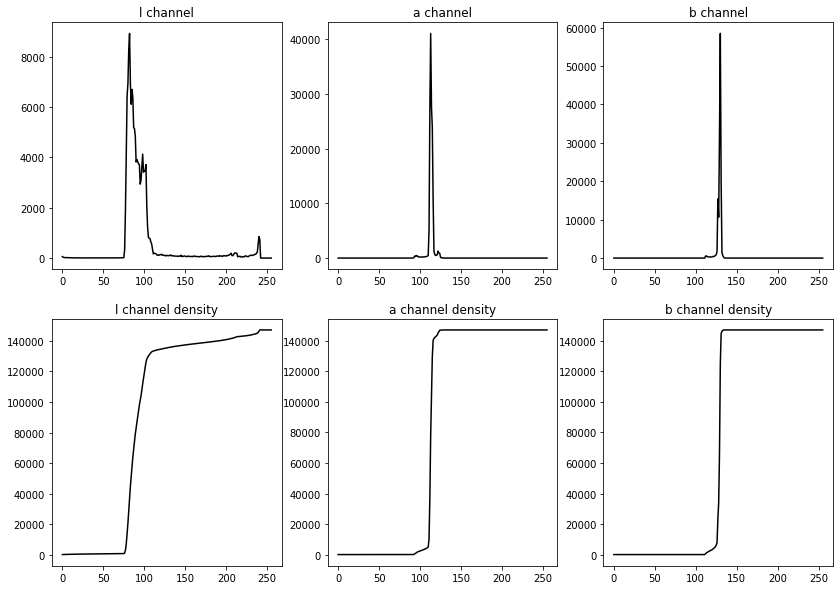

In [10]:
lab_hists = getHist( img_lab )
showHist(lab_hists, (14, 10))

241.0 127.0 136.0
0.0 0.0 0.0


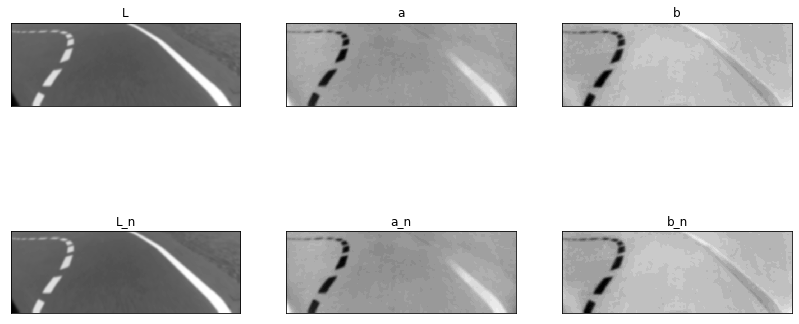

In [11]:
l, a, b = cv2.split(img_lab)
norm_l = cv2.normalize(l, None, alpha=0 , beta=np.max(l), norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
norm_a = cv2.normalize(a, None, alpha=0 , beta=np.max(a), norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
norm_b = cv2.normalize(b, None, alpha=0 , beta=np.max(b), norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

print( np.max(norm_l), np.max(norm_a), np.max(norm_b) )
print( np.min(norm_l), np.min(norm_a), np.min(norm_b) )

imgsShow( (l, a, b, norm_l, norm_a, norm_b), (2, 3), ("L", "a", "b", "L_n", "a_n", "b_n"), (14, 7) )

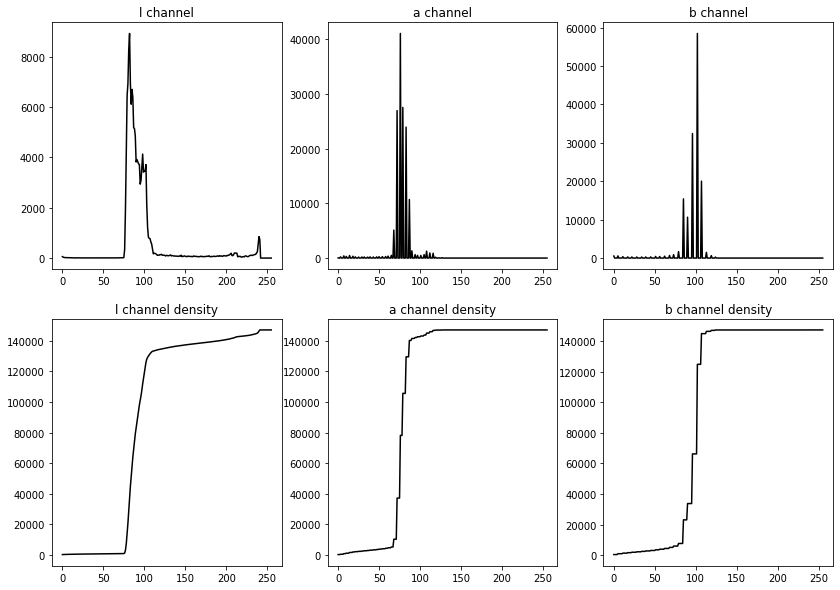

In [12]:
norm_hists = getHist( cv2.merge( (norm_l, norm_a, norm_b) ))
showHist(norm_hists, (14, 10))

mean, std_dev =  [129.00472147] [2.56862301]
r = 123.0
k =  [134.23159703]


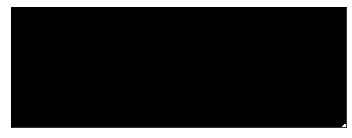

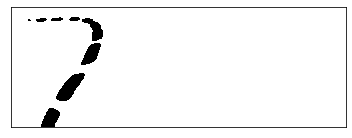

In [13]:
mean, dev = cv2.meanStdDev( b )
mean = mean[0]
dev = dev[0]
print("mean, std_dev = ", mean, dev)
koeff = 0.5

_, thresh_y = cv2.threshold( b, mean  + dev*(2+dev*2*np.sqrt(3)/(255)), 255, cv2.THRESH_BINARY)
ret, thresh_ot_y = cv2.threshold( b.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("r =", ret)
print("k = ", mean  + dev*(2+dev*2*np.sqrt(3)/(255)))
imgShow( thresh_y )
imgShow(thresh_ot_y)

mean, std_dev =  [97.6654144] [32.52944698]
r = 148.0
k =  [177.09917428]


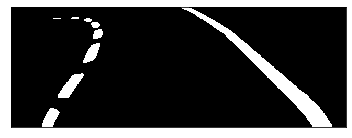

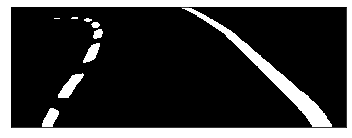

In [14]:
mean, dev = cv2.meanStdDev( l )
mean = mean[0]
dev = dev[0]
print("mean, std_dev = ", mean, dev)
koeff = 0.5

_, thresh_l = cv2.threshold( l, mean  + dev*(1+dev*2*np.sqrt(3)/(255)), 255, cv2.THRESH_BINARY)
ret, thresh_ot_l = cv2.threshold( l.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("r =", ret)
print("k = ", mean  + dev*(2+dev*2*np.sqrt(3)/(255)))
imgShow( thresh_l )
imgShow(thresh_ot_l)

88
113
130


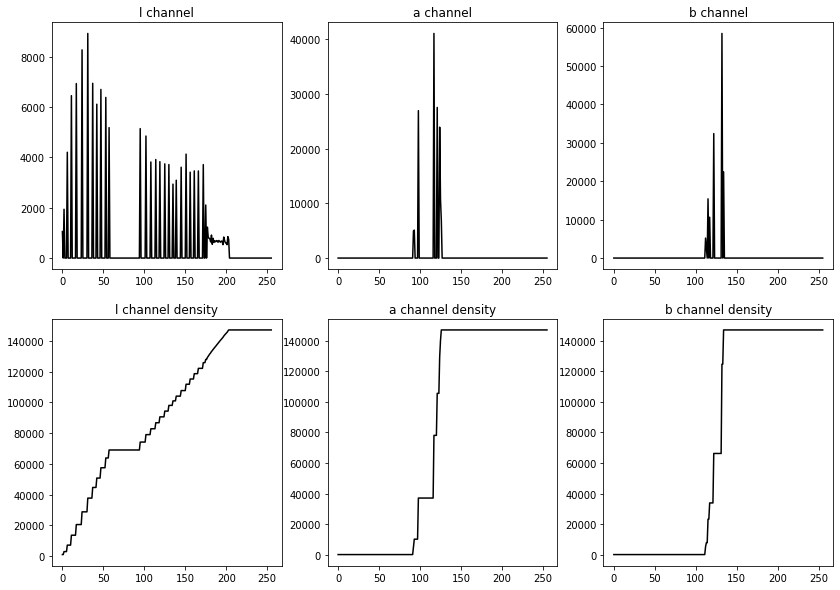

In [15]:
he_l = BHEMHB( dp(lab_hists[0]), dp(l) )
he_a = BHEMHB( dp(lab_hists[1]), dp(a) )
he_b = BHEMHB( dp(lab_hists[2]), dp(b) )

he_hists = getHist( cv2.merge( (he_l, he_a, he_b) ))
showHist(he_hists, (14, 10))

mean, std_dev =  [126.19816576] [7.48098836]
r = 122.0
k =  [133.99895519]


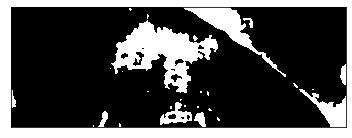

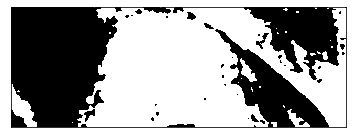

In [16]:
mean, dev = cv2.meanStdDev( he_b )
mean = mean[0]
dev = dev[0]
print("mean, std_dev = ", mean, dev)
koeff = 0.5

_, thresh_heb = cv2.threshold( he_b, mean  + dev*(1+dev/175), 255, cv2.THRESH_BINARY)
ret, thresh_ot_heb = cv2.threshold( he_b.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("r =", ret)
print("k = ", mean + dev*(1+dev/175))
imgShow( thresh_heb )
imgShow(thresh_ot_heb)

mean, std_dev =  [92.92524457] [63.7044866]
r = 57.0
k =  [188.33490001]


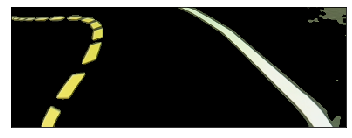

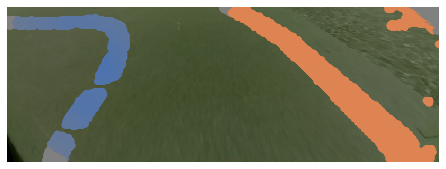

In [91]:
road = cv2.imread( "../images/jb_1.png" )
road = cv2.cvtColor( road, cv2.COLOR_BGR2RGB )
road = road[250:]

mean, dev = cv2.meanStdDev( he_l )
mean = mean[0]
dev = dev[0]
print("mean, std_dev = ", mean, dev)
koeff = 0.5

_, thresh_hel = cv2.threshold( he_l, mean  + dev*(0.5+dev*2*np.sqrt(3)/(255)), 255, cv2.THRESH_BINARY)
ret, thresh_ot_hel = cv2.threshold( he_l.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("r =", ret)
print("k = ", mean + dev*(1+dev/128))

clr_thresh = colorize_threshold(thresh_hel, road)


scale = 0.6
thresh_hel = cv2.resize(clr_thresh, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
road = cv2.resize(road, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)


mask = clusterize(thresh_hel, road)


# Video test

In [ ]:
video_path = "../images/video/"
video_path_clips = "../images/video/clips/"
cap = cv2.VideoCapture( video_path + 'yellow_line.webm')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')

bright_clip = cv2.VideoWriter(video_path_clips + 'bright.avi',fourcc, 20.0, (360,640))
cloudy_clip = cv2.VideoWriter(video_path_clips + 'cloudy.avi',fourcc, 20.0, (360, 640))
dark_clip = cv2.VideoWriter(video_path_clips + 'dark.avi',fourcc, 20.0, (360, 640))
pale_clip = cv2.VideoWriter(video_path_clips + 'pale.avi',fourcc, 20.0, (360, 640))

bright = []
cloudy = []
dark = []
pale = []

i = 0
while(cap.isOpened()):
    ret, frame = cap.read()

    if i > 2880 and i < 4320:
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        bright_clip.write(frame)
    elif i > 21600 and i < 23040:
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        cloudy_clip.write(frame)
    elif i > 276480 and i < 277920:
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        pale_clip.write(frame)
    elif i > 473760 and i < 475200:
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        dark_clip.write(frame)
    elif i == 475200:
        break
    
    i+=1
        

bright_clip.release()
cloudy_clip.release()
dark_clip.release()
pale_clip.release()
cap.release()

In [ ]:
l, a, b = cv2.split(frame)
b.shape

In [ ]:
video_path_res = "../images/video/res/"
video_path_clips = "../images/video/clips/"

#bright_cap = cv2.VideoCapture( video_path_clips + 'bright.avi')
#cloudy_cap = cv2.VideoCapture( video_path_clips + 'cloudy.avi')
#pale_cap = cv2.VideoCapture( video_path_clips + 'pale.avi')
#dark_cap = cv2.VideoCapture( video_path_clips + 'dark.avi')

# Define the codec and create VideoWriter object
#fourcc = cv2.VideoWriter_fourcc(*'XVID')

#bright_res_l = cv2.VideoWriter(video_path_res + 'bright_l.avi',fourcc, 20.0, (240,140))
#bright_res_b = cv2.VideoWriter(video_path_res + 'bright_b.avi',fourcc, 20.0, (240,140))
#cloudy_res_l = cv2.VideoWriter(video_path_res + 'cloudy_l.avi',fourcc, 20.0, (640,360))
#cloudy_res_b = cv2.VideoWriter(video_path_res + 'cloudy_b.avi',fourcc, 20.0, (640,360))
#dark_res_l = cv2.VideoWriter(video_path_res + 'dark_l.avi',fourcc, 20.0, (640,360))
#dark_res_b = cv2.VideoWriter(video_path_res + 'dark_b.avi',fourcc, 20.0, (640,360))
#pale_res_l = cv2.VideoWriter(video_path_res + 'pale_l.avi',fourcc, 20.0, (640,360))
#pale_res_b = cv2.VideoWriter(video_path_res + 'pale_b.avi',fourcc, 20.0, (640,360))

In [ ]:
def makeVideo(filename, output):

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    cap = cv2.VideoCapture( filename + ".avi" )
    res_l = cv2.VideoWriter(output + "_l.avi" ,fourcc, 20.0, (240,140))
    res_b = cv2.VideoWriter(output + "_b.avi" ,fourcc, 20.0, (240,140))
    res_otsu = cv2.VideoWriter(output + "_o.avi" ,fourcc, 20.0, (240,140))
    res_mask = cv2.VideoWriter(output + "_m.avi" ,fourcc, 20.0, (240,140))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        l, _, b = cv2.split(frame[220:,200:440 ])
    
        mean, dev = cv2.meanStdDev( l )
        mean = mean[0]
        dev = dev[0]
        _, white = cv2.threshold( l, mean  + dev*(2+dev*2*np.sqrt(3)/(255)), 255, cv2.THRESH_BINARY)
        #white = cv2.cvtColor(white, cv2.COLOR_GRAY2BGR)

        mean, dev = cv2.meanStdDev( b )
        mean = mean[0]
        dev = dev[0]
        _, yellow = cv2.threshold( b, mean  + dev*(2+dev*2*np.sqrt(3)/(255)), 255, cv2.THRESH_BINARY)
        yellow = cv2.cvtColor(yellow, cv2.COLOR_GRAY2BGR)
        
        _, otsu = cv2.threshold( b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        otsu = cv2.cvtColor(otsu, cv2.COLOR_GRAY2BGR)

        
        #thresh_hel = cv2.resize(thresh_hel, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        #road = cv2.resize(road, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        thresh_hel = white
        road = frame[220:, 200:440]
        mask = clusterize(thresh_hel, road)
        mask = cv2.resize(mask, (road.shape[1], road.shape[0]))
        
        white = cv2.cvtColor(white, cv2.COLOR_GRAY2BGR)
        res_l.write(white)
        res_b.write(yellow)
        res_otsu.write(otsu)
        res_mask.write(mask)
    
    res_l.release()
    res_b.release()
    res_otsu.release()
    cap.release()

In [ ]:
makeVideo(video_path_clips + 'bright', video_path_res + 'bright')
makeVideo(video_path_clips + 'cloudy', video_path_res + 'cloudy')
makeVideo(video_path_clips + 'pale', video_path_res + 'pale')
makeVideo(video_path_clips + 'dark', video_path_res + 'dark')

In [ ]:
imgShow(frame)